<a href="https://colab.research.google.com/github/condehub5/Trabajo-Final---Universidad-del-Pac-fico/blob/main/Trabajo_Final_Estimaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐟 Proyecto Final: Pronóstico de Variables de Pesca asociadas a demanda para Consumo Interno Nacional en el Perú (1991–2023)

Este proyecto tiene como objetivo estimar y proyectar la **Venta de productos pesqueros para consumo humano directo** en el Perú, utilizando datos oficiales proporcionados por el **Instituto Nacional de Estadística e Informática (INEI)**. La serie abarca desde enero de 1991 hasta diciembre de 2023 y representa una variable relevante para el análisis sectorial de alimentos, producción primaria y consumo nacional.

Contar con modelos de pronóstico confiables permite a entidades públicas, empresas pesqueras y actores de la cadena alimentaria anticipar fluctuaciones en la oferta y la demanda, y planificar de forma estratégica.

El análisis incluirá:

- Visualización exploratoria de la serie histórica.
- Aplicación de al menos tres modelos distintos para pronóstico:
  - **ARIMA:** Modelo estadístico tradicional para series temporales.
  - **Prophet:** Modelo aditivo desarrollado por Meta, adecuado para estacionalidad y tendencias.
  - **Random Forest Regressor:** Algoritmo de Machine Learning no paramétrico que aprovecha variables temporales como mes y año.

Los modelos serán evaluados en un periodo de prueba fuera de muestra mediante métricas como **MAE (Mean Absolute Error)** y **RMSE (Root Mean Squared Error)**. Finalmente, se realizará una interpretación financiera y estratégica de los resultados obtenidos.

---

In [2]:
import numpy as np
import pandas as pd #SIRVE PARA DATAFRAMES
import matplotlib.pyplot as plt #sirve para gráficos
import seaborn as sns #graficos al interior de matplotlib
from statsmodels.tsa.holtwinters import ExponentialSmoothing #para trabajar modelos de econometria
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from prophet import Prophet

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
dir()

['ExponentialSmoothing',
 'In',
 'KNeighborsRegressor',
 'Out',
 'Prophet',
 'RandomForestRegressor',
 'RandomizedSearchCV',
 'SARIMAX',
 'SVR',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i2',
 '_i3',
 '_i4',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'exit',
 'get_ipython',
 'np',
 'pd',
 'plot_acf',
 'plt',
 'quit',
 'seasonal_decompose',
 'sns',
 'uniform',
 'warnings']

🟦 SNIPPET 1 – Cargar el archivo Excel desde INEI

In [6]:
# 📂 Cargar archivo Excel con series pesqueras del INEI

# Ruta del archivo (debe estar en el mismo directorio o haber sido subido en Colab)
file_path = "Series INEI pesca.xlsx"

# Leer el archivo completo sin encabezados
xls = pd.ExcelFile(file_path)
df_full = xls.parse(xls.sheet_names[0], header=None)

In [7]:
# Extraer los años desde fila 3 (índice 2), columnas D en adelante
anios = df_full.iloc[2, 3:].values
anios = pd.to_datetime([f"{int(a)}-12-31" for a in anios if pd.notnull(a)])

# Extraer nombre, unidad y valores desde fila 4 (índice 3)
nombre = df_full.iloc[3, 1]   # Columna B
unidad = df_full.iloc[3, 2]   # Columna C
valores = df_full.iloc[3, 3:3 + len(anios)]  # Desde columna D

# Convertir a números válidos
valores = pd.to_numeric(valores.astype(str).str.replace(",", "."), errors='coerce')

# Crear DataFrame vertical
df_una_serie = pd.DataFrame({
    'fecha': anios,
    'valor': valores,
    'variable': nombre.strip(),
    'unidad': unidad.strip()
})

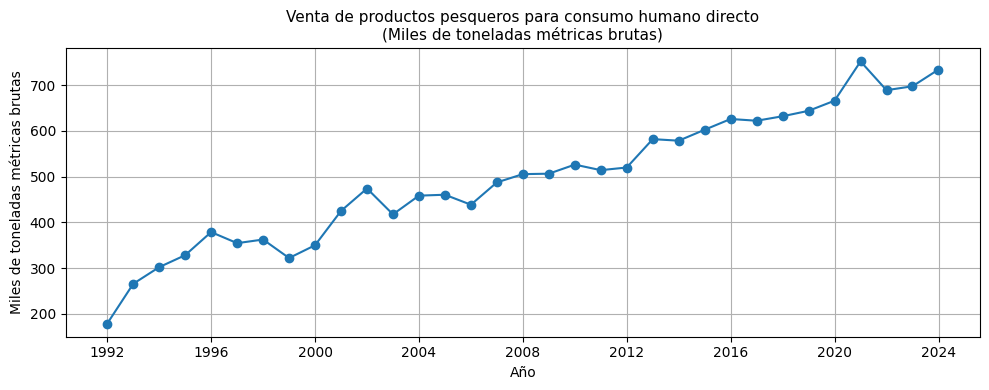

In [8]:
# Graficar evolución histórica
plt.figure(figsize=(10, 4))
plt.plot(df_una_serie['fecha'], df_una_serie['valor'], marker='o')
plt.title(f"{df_una_serie['variable'].iloc[0]}\n({df_una_serie['unidad'].iloc[0]})", fontsize=11)
plt.xlabel("Año")
plt.ylabel(df_una_serie['unidad'].iloc[0])
plt.grid(True)
plt.tight_layout()
plt.show()

###  **Promedio móvil (rolling mean)**

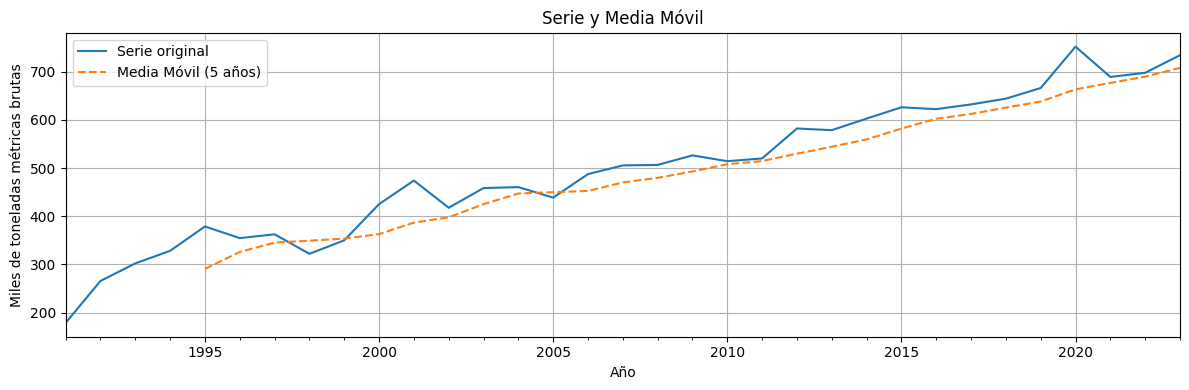

In [9]:
# Gráfico de la serie original junto a su media móvil de 5 años
plt.figure(figsize=(12, 4))

# Convertir a serie temporal con frecuencia anual
serie = df_una_serie.set_index('fecha')['valor'].asfreq('Y')

# Interpolación por si hubiera valores faltantes
serie = serie.interpolate(method='linear', limit_direction='both')

# Serie original
serie.plot(label='Serie original')

# Media móvil (ajustable: 5 o 10 años)
serie.rolling(window=5).mean().plot(label='Media Móvil (5 años)', linestyle='--')

# Etiquetas y leyenda
plt.title("Serie y Media Móvil")
plt.xlabel("Año")
plt.ylabel(df_una_serie['unidad'].iloc[0])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Promedio móvil exponencial (EWMA)**

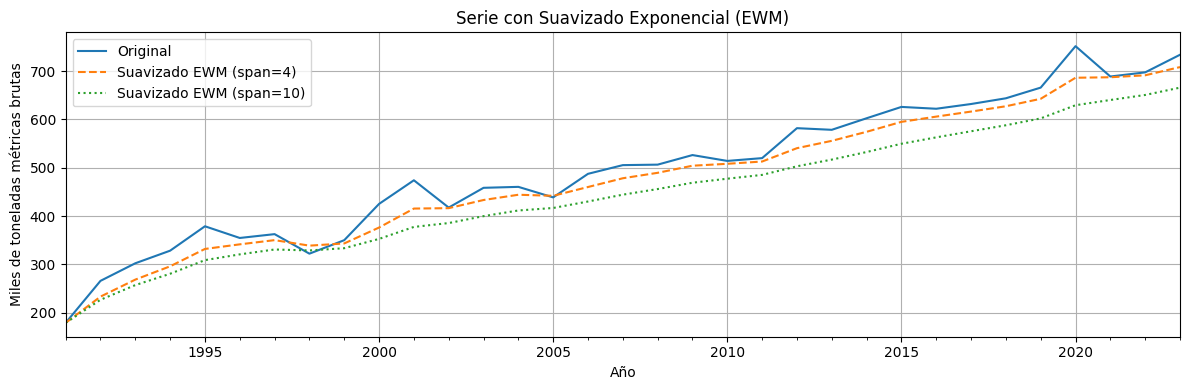

In [10]:
plt.figure(figsize=(12, 4))

# Serie original
serie.plot(label='Original')

# Suavizado exponencial con span=4 (más sensible)
serie.ewm(span=4).mean().plot(label='Suavizado EWM (span=4)', linestyle='--')

# Suavizado exponencial con span=10 (más suave)
serie.ewm(span=10).mean().plot(label='Suavizado EWM (span=10)', linestyle=':')

# Detalles del gráfico
plt.title("Serie con Suavizado Exponencial (EWM)")
plt.xlabel("Año")
plt.ylabel(df_una_serie['unidad'].iloc[0])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Tendencia LOESS (o LOWESS)**


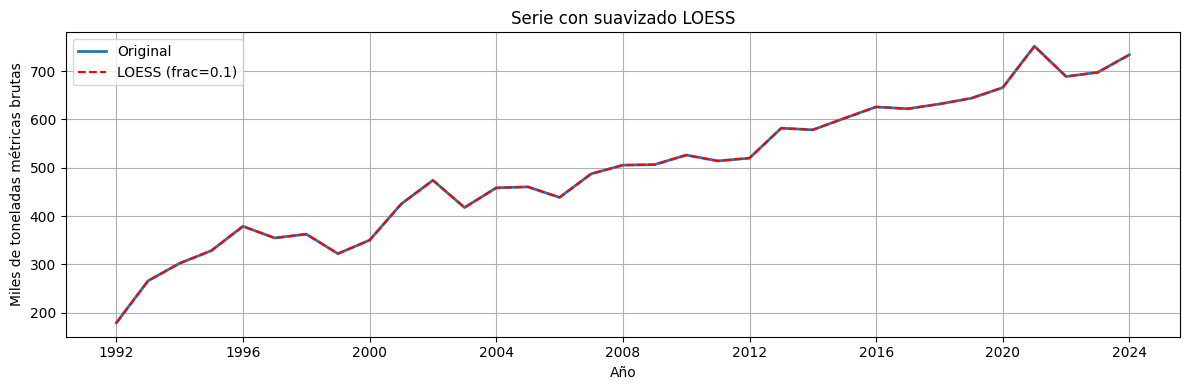

In [11]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import matplotlib.pyplot as plt

# Aplicar LOWESS (frac controla el grado de suavizado: 0.1 es poco, 0.3 o más es más suave)
loess = lowess(serie.values, np.arange(len(serie)), frac=0.1)

# Graficar la serie original y su suavizado LOESS
plt.figure(figsize=(12, 4))
plt.plot(serie.index, serie.values, label='Original', linewidth=2)
plt.plot(serie.index, loess[:, 1], label='LOESS (frac=0.1)', color='red', linestyle='--')
plt.title("Serie con suavizado LOESS")
plt.xlabel("Año")
plt.ylabel(df_una_serie['unidad'].iloc[0])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Modelo de Tendencia Lineal (Utilizando MCO)**

In [12]:
# Trabajamos con una serie df
df=serie
df

,valor
fecha,
1991-12-31,178.800000
1992-12-31,265.800000
1993-12-31,302.200000
1994-12-31,328.300000
1995-12-31,378.800000
1996-12-31,354.600000
1997-12-31,362.529000
1998-12-31,322.097000
1999-12-31,350.020000


In [13]:
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 33 entries, 1991-12-31 to 2023-12-31
Freq: YE-DEC
Series name: valor
Non-Null Count  Dtype  
--------------  -----  
33 non-null     float64
dtypes: float64(1)
memory usage: 528.0 bytes


In [14]:
df.index[-1]

Timestamp('2023-12-31 00:00:00')

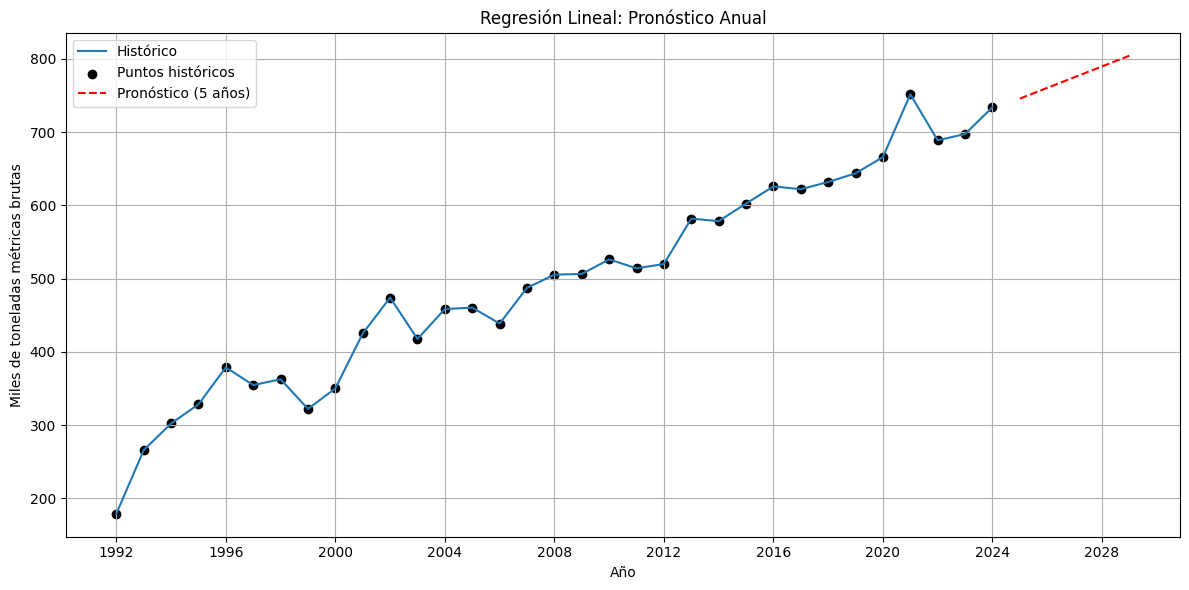

In [15]:
from sklearn.linear_model import LinearRegression
# Paso 1: Preparar DataFrame con variable t
df = serie.reset_index()                     # Reiniciar índice
df.columns = ['fecha', 'valor']              # Renombrar columnas
df['t'] = np.arange(len(df))                 # Crear variable temporal t

# Remove the row with the non-numeric value in the 'valor' column
df = df[pd.to_numeric(df['valor'], errors='coerce').notna()]

# Paso 2: Entrenar el modelo de regresión lineal
X = df[['t']]                                # Variable independiente
y = df['valor']                              # Variable dependiente
modelo = LinearRegression()
modelo.fit(X, y)

# Paso 3: Pronosticar los próximos 5 años
n_futuro = 5
t_futuro = np.arange(len(df), len(df) + n_futuro).reshape(-1, 1)
y_futuro = modelo.predict(t_futuro)

# Paso 4: Generar fechas anuales futuras
fechas_futuras = pd.date_range(start=df['fecha'].iloc[-1] + pd.DateOffset(years=1),
                                periods=n_futuro, freq='Y')

# Paso 5: Crear DataFrame de pronóstico
df_futuro = pd.DataFrame({'fecha': fechas_futuras, 'valor': y_futuro})

# Paso 6: Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(df['fecha'], df['valor'], label='Histórico')
plt.scatter(df['fecha'], df['valor'], label='Puntos históricos', color='black')
plt.plot(df_futuro['fecha'], df_futuro['valor'], linestyle='--', color='red', label='Pronóstico (5 años)')
plt.title('Regresión Lineal: Pronóstico Anual')
plt.xlabel('Año')
plt.ylabel(df_una_serie['unidad'].iloc[0])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Mostrar coeficientes del modelo
print("Coeficiente (pendiente):", modelo.coef_[0])
print("Intercepto:", modelo.intercept_)

Coeficiente (pendiente): 14.63568425693208
Intercepto: 262.8237872995807


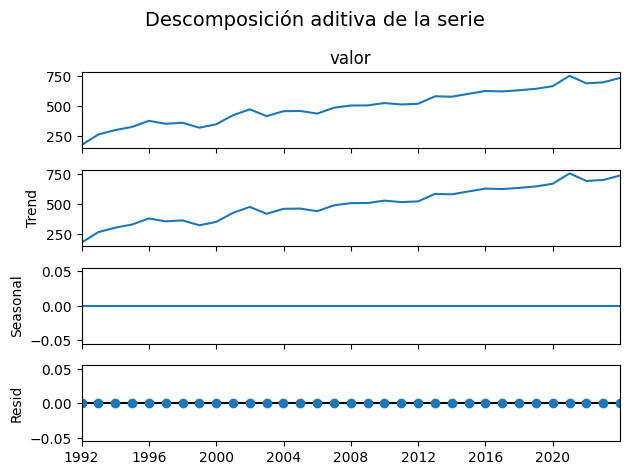

In [17]:
# DESCOMPOSICIÓN ESTACIONAL
from statsmodels.tsa.seasonal import seasonal_decompose

# Convertir a serie temporal con frecuencia anual
serie = df_una_serie.set_index('fecha')['valor'].asfreq('Y')

# Interpolación por si hubiera valores faltantes
serie = serie.interpolate(method='linear', limit_direction='both')

# Descomposición aditiva (period=1 ya que es serie anual)
decomposition = seasonal_decompose(serie, model='additive', period=1)
decomposition.plot()
plt.suptitle("Descomposición aditiva de la serie", fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
def get_forecast(serie, n_step, type='hw'):
    """
    Realiza pronóstico para una serie anual usando Holt-Winters, SARIMA o Prophet.
    Parámetros:
        - serie: pd.Series con índice de fechas (anuales)
        - n_step: número de pasos a futuro (años)
        - type: 'hw', 'sarima' o 'prophet'
    Retorna:
        - Serie de pronóstico con índice de años
    """
    if type == 'hw':
        # Holt-Winters without seasonality for annual data
        hw_model = ExponentialSmoothing(serie, trend='add', seasonal=None)
        hw_fit = hw_model.fit()
        forecast = hw_fit.forecast(steps=n_step)
        return forecast

    elif type == 'sarima':
        # SARIMA with no seasonality for annual data
        sarima_model = SARIMAX(serie, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
        sarima_fit = sarima_model.fit(disp=False)
        forecast = sarima_fit.forecast(steps=n_step)
        return forecast

    elif type == 'prophet':
        # Preparar DataFrame para Prophet
        df = serie.reset_index()
        df.columns = ['ds', 'y']

        # Instanciar modelo Prophet con configuración sin estacionalidad semanal
        prophet_model = Prophet(
            daily_seasonality=False,
            yearly_seasonality=False,
            weekly_seasonality=False,
            seasonality_mode='additive'
        )
        prophet_model.fit(df)

        # Crear fechas anuales futuras
        future = prophet_model.make_future_dataframe(periods=n_step, freq='Y')
        forecast = prophet_model.predict(future)

        # Extract and align only the final forecast
        pred_index = pd.date_range(start=serie.index[-1] + pd.DateOffset(years=1), periods=n_step, freq='Y')
        prophet_forecast = pd.Series(forecast.yhat[-n_step:].values, index=pred_index)
        return prophet_forecast

In [19]:
n_step = 5

In [20]:
# Ejecutar pronóstico con Holt-Winters
forecast_hw = get_forecast(serie, n_step, type='hw')

# Ejecutar pronóstico con SARIMA
forecast_sar = get_forecast(serie, n_step, type='sarima')

# Ejecutar pronóstico con Prophet
forecast_prop = get_forecast(serie, n_step, type='prophet')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvc22rzqc/az9fqysh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvc22rzqc/kejn_8ne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83473', 'data', 'file=/tmp/tmpvc22rzqc/az9fqysh.json', 'init=/tmp/tmpvc22rzqc/kejn_8ne.json', 'output', 'file=/tmp/tmpvc22rzqc/prophet_model9ef7lbjj/prophet_model-20250629152959.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:29:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


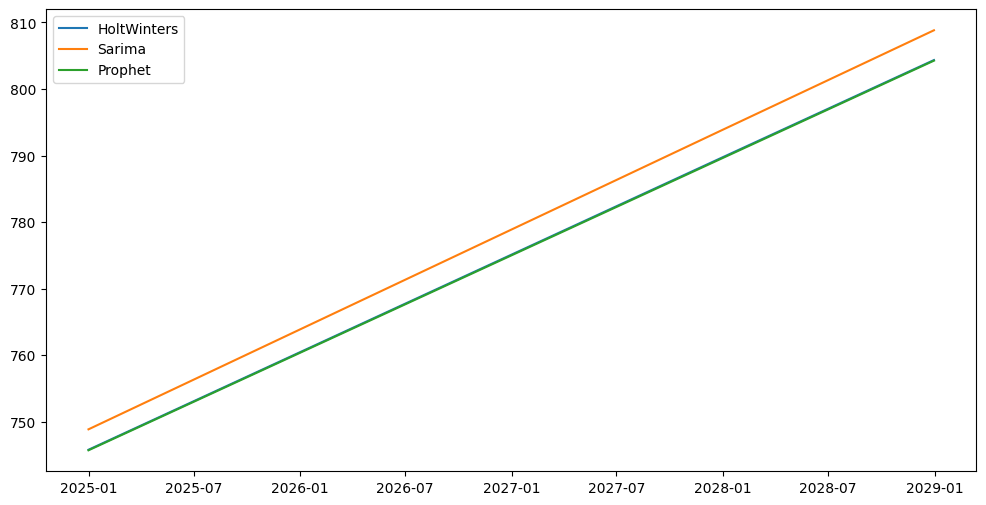

In [21]:
fig, ax =plt.subplots(figsize=(12,6))
ax.plot(forecast_hw,label='HoltWinters')
ax.plot(forecast_sar,label='Sarima')
ax.plot(forecast_prop,label='Prophet')
#ax.plot(serie,label='Real')
ax.legend()
fig.show()

<Axes: xlabel='fecha'>

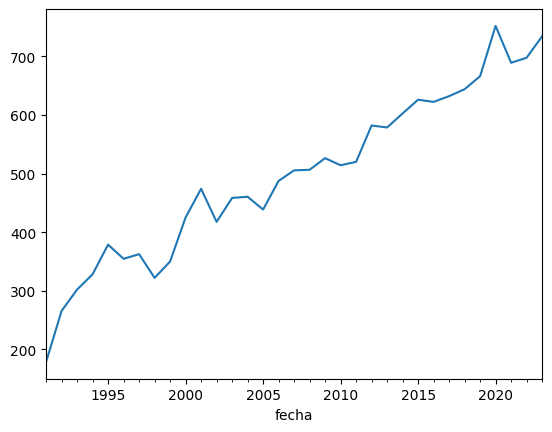

In [22]:
serie.plot()

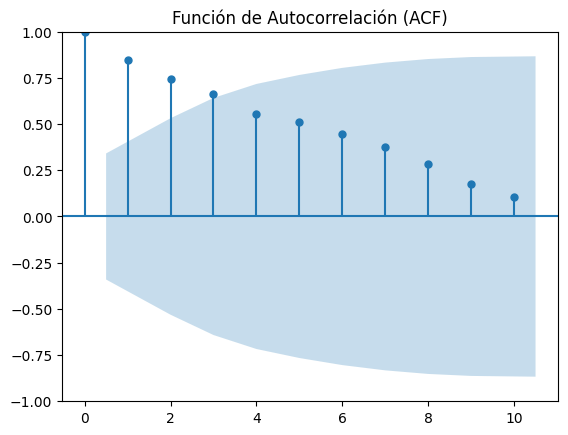

In [36]:
# Gráfica de autocorrelación
plot_acf(serie, lags=10)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

<Axes: xlabel='fecha'>

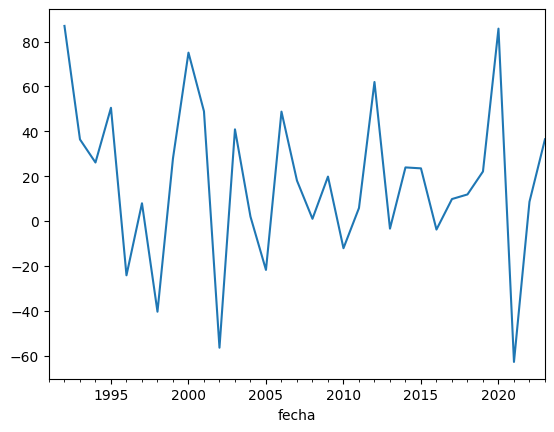

In [23]:
serie.diff().plot()

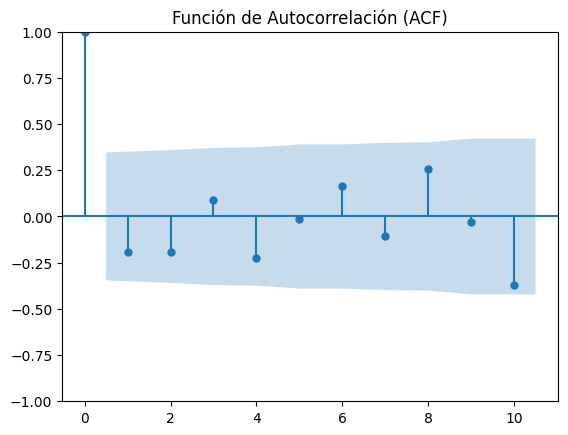

In [24]:
# Gráfica de autocorrelación
plot_acf(serie.diff().dropna(), lags=10)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

<Axes: xlabel='fecha'>

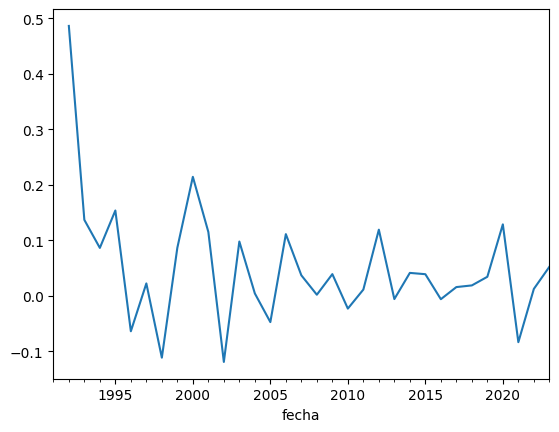

In [25]:
serie.pct_change().plot()

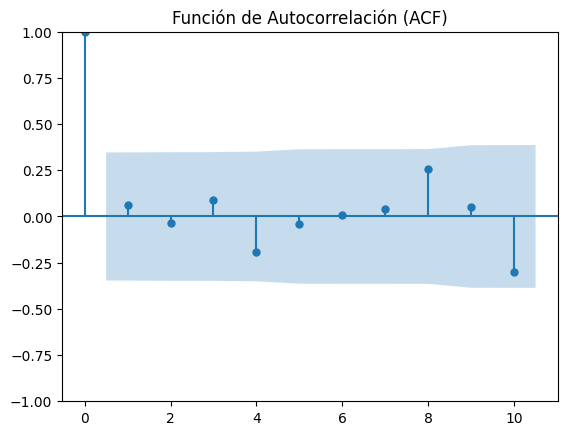

In [26]:
# Gráfica de autocorrelación
plot_acf(serie.pct_change().dropna(), lags=10)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

<Axes: xlabel='fecha'>

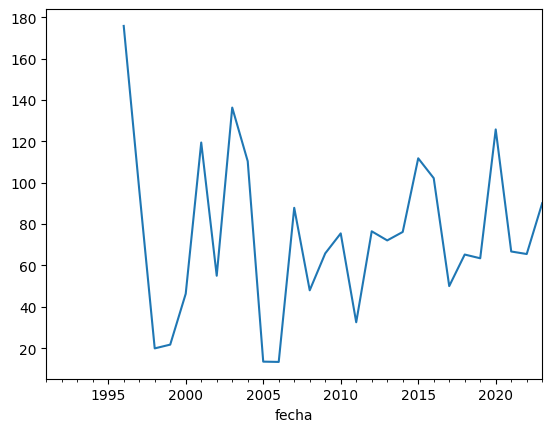

In [29]:
serie.diff(5).plot()

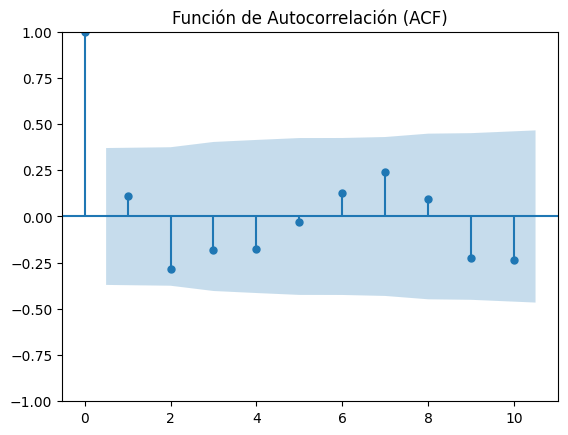

In [30]:
# Gráfica de autocorrelación
plot_acf(serie.diff(5).dropna(), lags=10)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

In [31]:
eval = serie.pct_change(7).reset_index()
eval['lag'] = eval['valor'].shift(7)
eval.head(15)

,fecha,valor,lag
0,1991-12-31,NaN,NaN
1,1992-12-31,NaN,NaN
2,1993-12-31,NaN,NaN
3,1994-12-31,NaN,NaN
4,1995-12-31,NaN,NaN
5,1996-12-31,NaN,NaN
6,1997-12-31,NaN,NaN
7,1998-12-31,0.801437,NaN
8,1999-12-31,0.316855,NaN
9,2000-12-31,0.406714,NaN


<Axes: xlabel='lag', ylabel='valor'>

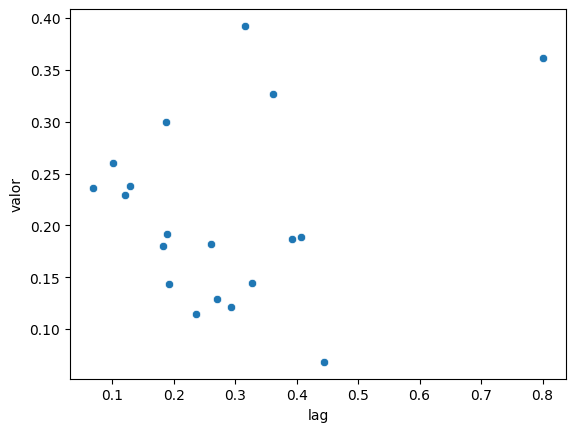

In [39]:
eval.dropna(inplace=True)
eval = eval.sort_values('lag')
sns.scatterplot(eval,x='lag',y='valor')

**Modelos de Machine Learning**

🔶 Random Forest
Se entrena sobre un DataFrame con variables como día, semana, mes, etc.

Se realiza búsqueda de hiperparámetros con RandomizedSearchCV.

🔵 KNN Regressor
Se usa sobre una matriz de features derivadas de la fecha.

Sensible a la escala de los datos, posible normalización.

⚫ SVR (Support Vector Regression)
Requiere escalamiento (MinMaxScaler o StandardScaler).

También se entrena sobre variables temporales derivadas.

In [40]:
x,y = eval[['lag']],eval['valor']

Text(0.5, 1.0, 'Modelo Random Forest')

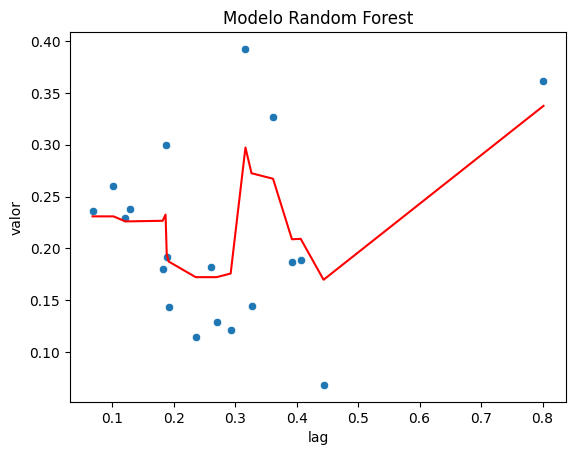

In [41]:
model = RandomForestRegressor(n_estimators=10, max_depth=3)
model.fit(x,y)
y_pred = model.predict(x)
sns.scatterplot(eval,x='lag',y='valor')
plt.plot(x,y_pred,c='red')
plt.title("Modelo Random Forest")

Text(0.5, 1.0, 'Modelo KNN')

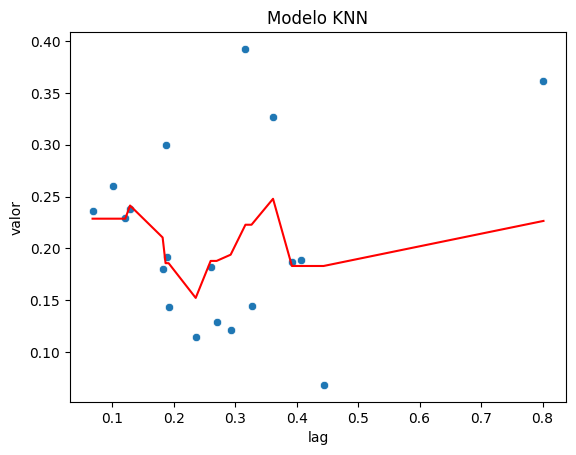

In [43]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(x,y)
y_pred = model.predict(x)
sns.scatterplot(eval,x='lag',y='valor')
plt.plot(x,y_pred,c='red')
plt.title("Modelo KNN")

In [44]:
# Distribuciones para búsqueda aleatoria
param_dist = {
    'C': uniform(0.1, 100),          # Valores entre 0.1 y 100
    'epsilon': uniform(0.01, 0.5),   # Valores entre 0.01 y 0.5
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'poly']
}

# Búsqueda aleatoria
model = RandomizedSearchCV(SVR(), param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Text(0.5, 1.0, 'Modelo SVR')

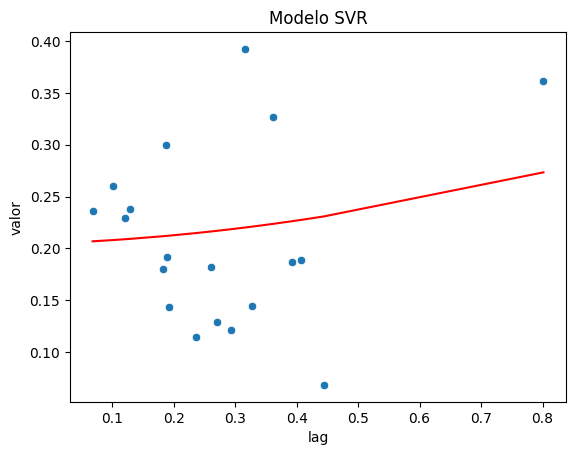

In [46]:
model.fit(x,y)
y_pred = model.predict(x)
sns.scatterplot(eval,x='lag',y='valor')
plt.plot(x,y_pred,c='red')
plt.title("Modelo SVR")

In [48]:
eval.sort_values('fecha').head()

,fecha,valor,lag
14,2005-12-31,0.361702,0.801437
15,2006-12-31,0.392438,0.316855
16,2007-12-31,0.188872,0.406714
17,2008-12-31,0.068291,0.443887
18,2009-12-31,0.260274,0.102281
